In [3]:
import sys
import os
import pandas as pd
import polars as pl
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")


if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)

from utils.paths import PICARRO_DATA_DIRECTORY, PROCESSED_PICARRO_DATA_DIRECTORY

assert(os.path.exists(PICARRO_DATA_DIRECTORY))
assert(os.path.exists(PROCESSED_PICARRO_DATA_DIRECTORY))

In [4]:
def merge_picarro_files(input_path:str, output_path:str, output_name:str="picarro"):
    """Example Path: .../BaseFolder/Year/Month/Day/*.dat
    
    input_path:str = ".../BaseFolder"
    
    """
    path = os.path.join(input_path, "*/*/*/*.dat")
    filenames = glob.glob(path)
    

    df_list = []
    #read all files into pandas dataframe
    for filename in filenames:
        df_list.append(pd.read_csv(filename,sep='\s+'))

    # concat all read files
    df_picarro = pd.concat(df_list, ignore_index=True)
    
    # calculate datetime object for dataframe and sort by time
    df_picarro["datetime"] = pd.to_datetime((df_picarro['DATE'] + ' ' + df_picarro['TIME']))
    df_picarro.sort_values(by='datetime', inplace = True)
    
    # fix: some value seems to be a int in this float column
    df_picarro.EtalonTemp = pd.to_numeric(df_picarro.EtalonTemp, errors='coerce').fillna(0).astype(np.float64)
    
    # save dataframe as parquet file
    df_picarro.to_parquet(path = f"{output_path}/{output_name}.parquet")
    
    return df_picarro

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/y4/db3wnfk51k5977sk937k5q140000gn/T/ipykernel_1717/2839495103.py:14: SyntaxWarning: invalid escape sequence '\s'
  df_list.append(pd.read_csv(filename,sep='\s+'))


In [ ]:
# DWD Picarro G2301 ID413
print("Starting read for DWD Picarro G2301 ID413.")
path = os.path.join(PICARRO_DATA_DIRECTORY, "DWD_Picarro_G2301_413")
#df_p_413 = merge_picarro_files(input_path=path, output_path=PROCESSED_PICARRO_DATA_DIRECTORY, output_name="DWD_Picarro_G2301_413")
print("Finished read for DWD Picarro G2301 ID413.")

# LSCE Picarro G2401 ID520
print("Starting read for ICOS_Picarro_G2401_529.")
#path = os.path.join(PICARRO_DATA_DIRECTORY, "ICOS_Picarro_G2401_529")
#df_p_529 = merge_picarro_files(input_path=path, output_path=PROCESSED_PICARRO_DATA_DIRECTORY, output_name="ICOS_Picarro_G2401_529")
print("Starting read for ICOS_Picarro_G2401_529.")

Starting read for DWD Picarro G2301 ID413.
Finished read for DWD Picarro G2301 ID413.
Starting read for ICOS_Picarro_G2401_529.
Starting read for ICOS_Picarro_G2401_529.


In [7]:
df_p_413.head(1)

,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime
25156741,2023-07-01,00:00:01.150,181.000013,4344.000319,182.000013,1.688170e+09,0,963,140.012831,44.99987,...,421.023033,433.462829,2.274335,1181.940043,82.55631,1084.999673,78.542541,-0.074797,-0.045017,2023-07-01 00:00:01.150


/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


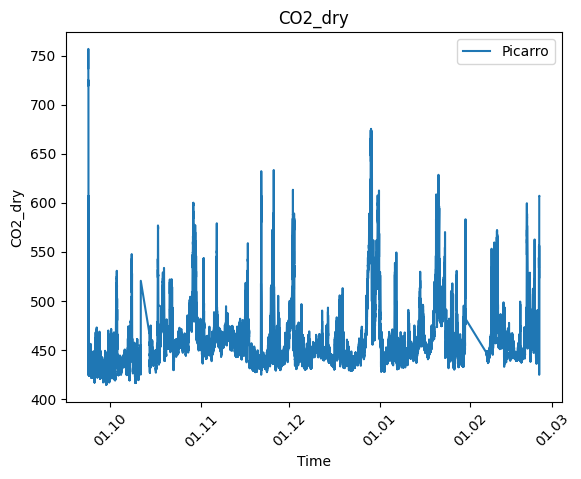

In [16]:
df_plot = df_p_529[["datetime", "CO2_dry"]] \
    .loc[(df_p_529['CO2_dry'] > 300) & (df_p_529['CO2_dry'] < 1000)] \
    .set_index("datetime") \
    .resample('1min').mean() 
    
sns.lineplot(data=df_plot,x='datetime',y="CO2_dry",label="Picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2_dry')
plt.xticks(rotation=45)

# plt.legend(title="Systems", bbox_to_anchor=(1, 1))
plt.title(label='CO2_dry')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()